# Machine Learning Exam 20/04/2025
Workflow
1. Import, data loading, set general variables and visualization
2. Train-test split and generation of the reference estimator
3. Cross-validation with hyperparameter optimization
4. Feature selection with `SelectKBest`
5. Cross-validation with hyperparameter optimization on the reduced dataset after feature selection


## 1. Imports data loading and visualization

In [3]:
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay
from sklearn.feature_selection import SelectKBest, mutual_info_classif
import matplotlib.pyplot as plt
from functools import partial
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
# .....


random_state = 42
cv = 5
test_set_size = 0.33
scoring = 'accuracy'

path = 'spambase.data'

Load the file `spambase.data` into a pandas DataFrame. 

The last column denotes whether the e-mail was considered spam or not, so it's the target of the classification task (class).

In [4]:
data=pd.read_csv(path, header=None)
data.head()

,0,1,2,3,4,5,6,7,8,9,...,48,49,50,51,52,53,54,55,56,57
0,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.00,0.00,...,0.00,0.000,0.0,0.778,0.000,0.000,3.756,61,278,1
1,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,...,0.00,0.132,0.0,0.372,0.180,0.048,5.114,101,1028,1
2,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,...,0.01,0.143,0.0,0.276,0.184,0.010,9.821,485,2259,1
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.137,0.0,0.137,0.000,0.000,3.537,40,191,1
4,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.135,0.0,0.135,0.000,0.000,3.537,40,191,1


Separate predicting feature and target, show the respective shapes

In [5]:
target=57
X = data.drop(target, axis=1)
y = data[target]
print(X.shape)
print(y.shape)


(4601, 57)
(4601,)


Plot the histograms of the features and the class.

array([[<Axes: title={'center': '0'}>, <Axes: title={'center': '1'}>,
        <Axes: title={'center': '2'}>, <Axes: title={'center': '3'}>,
        <Axes: title={'center': '4'}>, <Axes: title={'center': '5'}>,
        <Axes: title={'center': '6'}>, <Axes: title={'center': '7'}>],
       [<Axes: title={'center': '8'}>, <Axes: title={'center': '9'}>,
        <Axes: title={'center': '10'}>, <Axes: title={'center': '11'}>,
        <Axes: title={'center': '12'}>, <Axes: title={'center': '13'}>,
        <Axes: title={'center': '14'}>, <Axes: title={'center': '15'}>],
       [<Axes: title={'center': '16'}>, <Axes: title={'center': '17'}>,
        <Axes: title={'center': '18'}>, <Axes: title={'center': '19'}>,
        <Axes: title={'center': '20'}>, <Axes: title={'center': '21'}>,
        <Axes: title={'center': '22'}>, <Axes: title={'center': '23'}>],
       [<Axes: title={'center': '24'}>, <Axes: title={'center': '25'}>,
        <Axes: title={'center': '26'}>, <Axes: title={'center': '27'}>,

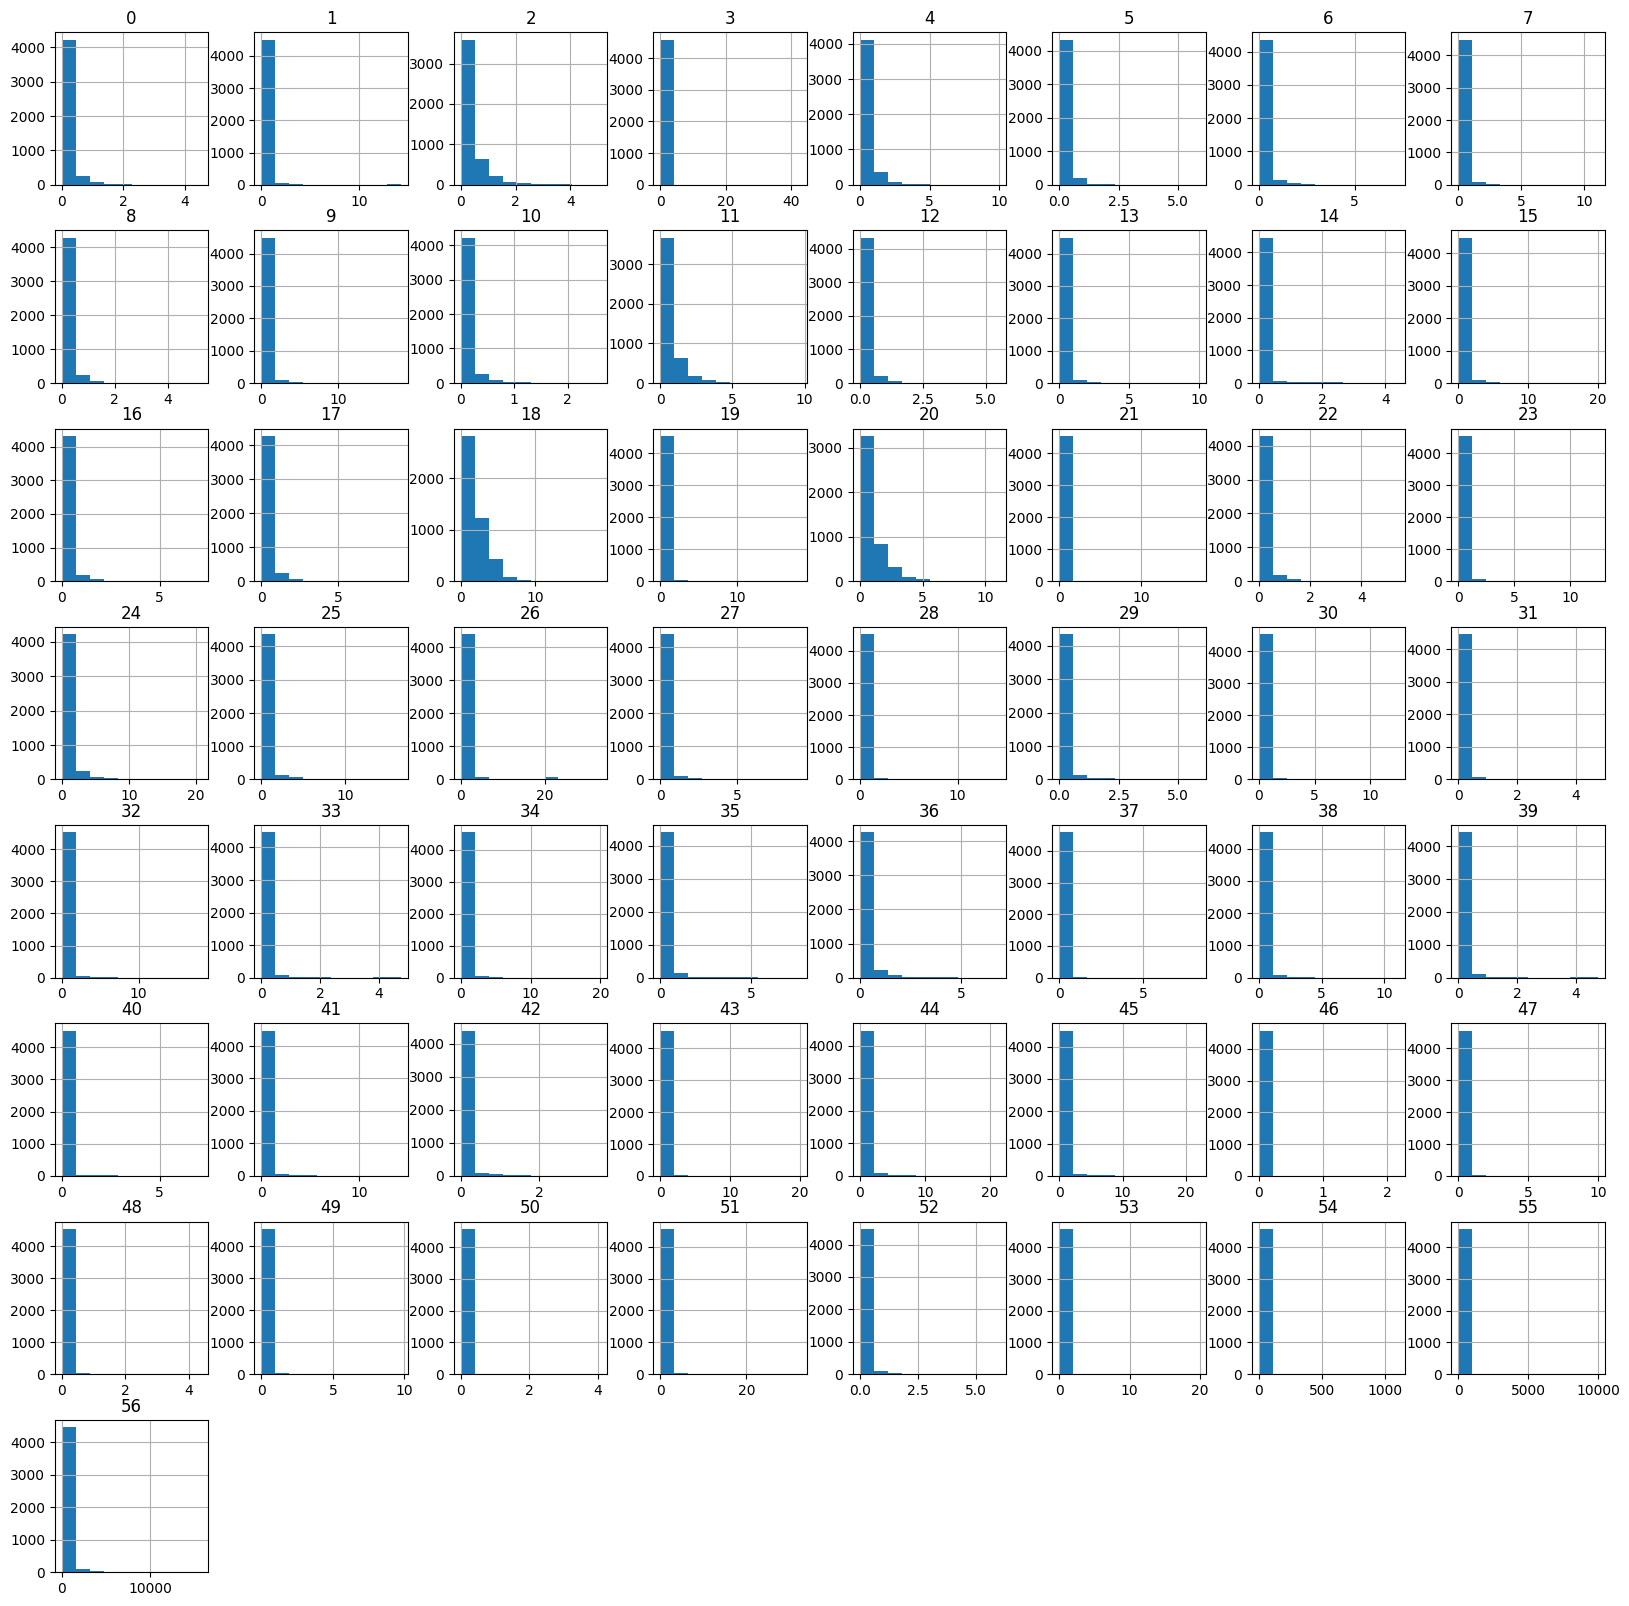

In [6]:
X.hist(figsize=(20, 20))


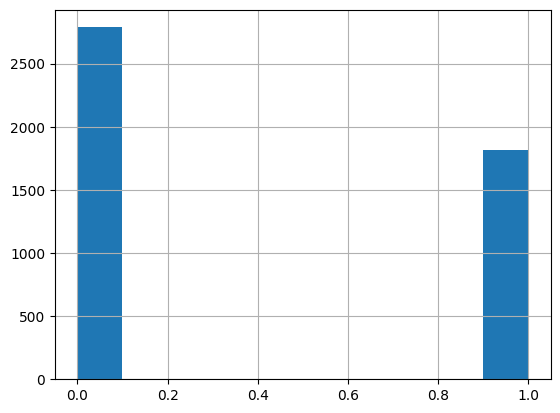

In [7]:
y.hist()
plt.show()

Show the boxplots of the features, split it into two figures if it doesn't fit the page.

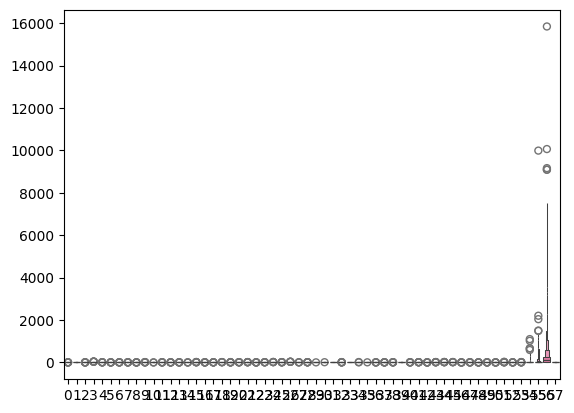

In [8]:
sns.boxenplot(data=data)
plt.show()

## 2. Train-test split and reference estimator

Split into train and test (`test_size=0.33`), then fit a `DecisionTreeClassifier` and observe its `max_depth`. Initialize the estimator with the parameter `criterion="entropy"`.

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_set_size, random_state=random_state)
estimator = DecisionTreeClassifier(random_state=random_state, criterion='entropy')
estimator.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', random_state=42)

Train the reference estimator and show the maximum depth of the unpruned tree

In [10]:
y_predicted_train = estimator.predict(X_train)
accuracy_train = accuracy_score(y_predicted_train, y_train)*100
fitted_max_depth = estimator.tree_.max_depth
print(f'The max depth of the reference estimator is : {fitted_max_depth}')


The max depth of the reference estimator is : 25


Predict train and test and show the respective accuracies

In [11]:
y_predicted_test = estimator.predict(X_test)
accuracy_ho_test = accuracy_score(y_test, y_predicted_test) * 100
print("The accuracy on Training set is {0:.1f}%".format(accuracy_train))
print("The accuracy on Test set is {0:.1f}%".format(accuracy_ho_test))


The accuracy on Training set is 100.0%
The accuracy on Test set is 91.2%


## 3. Cross validation with hyperparameter optimization

Tune the `max_depth` and `criterion` hyperparameters using cross validation.

In [16]:
tuned_param_dt = [{'max_depth': [*range(1,12)]
                , 'criterion' : ['entropy', 'gini']
                , 'class_weight' : [None, 'balanced']}]
scorings = ['accuracy']
for scoring in scorings:
    clf = DecisionTreeClassifier(random_state=random_state)
    clf = GridSearchCV(clf, tuned_param_dt, cv=cv, scoring=scoring)
    clf.fit(X_train, y_train)
    print(f'Best parameters found: {clf.best_params_}')


Best parameters found: {'class_weight': None, 'criterion': 'entropy', 'max_depth': 11}


Fit a `DecisionTreeClassifier` with the best parameter and print the training set score, cross-validation score and the test set score.

In [24]:
best_params = clf.best_params_
clf = DecisionTreeClassifier(random_state=random_state, criterion=best_params['criterion'], max_depth=best_params['max_depth'], class_weight=best_params['class_weight'])
clf = GridSearchCV(clf, tuned_param_dt, cv=cv, scoring=scoring)
clf.fit(X_test, y_test)
y_predicted_cv = clf.predict(X_test)
accuracy_ho_cv = accuracy_score(y_test, y_predicted_cv) * 100
print("Train set accuracy: {0:.1f}%".format(accuracy_train))
print('Best Cross validation accuracy: {0:.1f}%'.format(accuracy_ho_cv))
print(" Test set accuracy: {0:.1f}%".format(accuracy_ho_test))

Train set accuracy: 100.0%
Best Cross validation accuracy: 96.5%
 Test set accuracy: 91.2%


## 4. Feature selection

Create a pipeline with `SelectKBest` (using `mutual_info_classif` as score function) and `DecisionTreeClassifier`, 

Optimize the pipline with cross validation with respect to the number of feaures to keep. For the decision tree use the best parameters found in step 3.

Fit with the best estimator, predict and show all the results.

In [20]:
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif

param_grid_p = {
    'kbest__k': list(range(1, X.shape[1] + 1))
}

# pipeline creation
pipeline = Pipeline([
    ('kbest', SelectKBest(score_func=partial(mutual_info_classif, random_state=random_state))),
    ('dt', DecisionTreeClassifier(criterion=best_params['criterion']
                                  ,max_depth=best_params['max_depth']
                                  ,random_state=random_state))
])

In [22]:
dataset='Reduced dataset'
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_set_size, random_state=random_state)
kbest= SelectKBest(mutual_info_classif, k=11)
X_train_kbest = kbest.fit_transform(X_train, y_train)
X_test_kbest = kbest.transform(X_test)
print(dataset)
print("Train set accuracy: {0:.1f}%".format(accuracy_train))
print('Best Cross validation accuracy: {0:.1f}%'.format(accuracy_ho_cv))
print(" Test set accuracy: {0:.1f}%".format(accuracy_ho_test))



Reduced dataset
Train set accuracy: 100.0%
Best Cross validation accuracy: 96.5%
 Test set accuracy: 91.2%


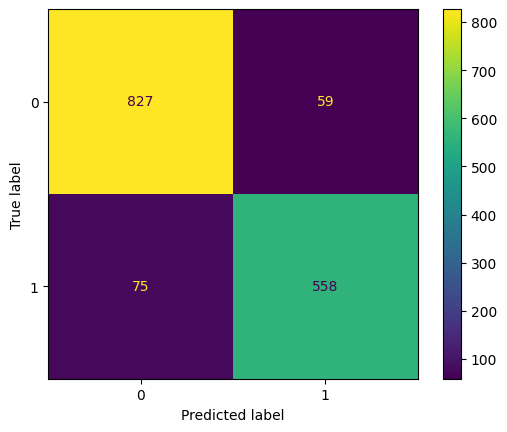

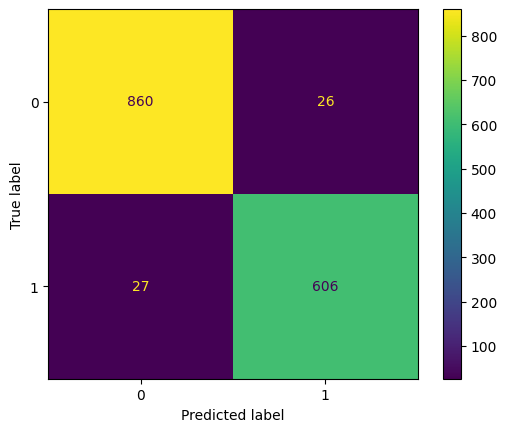

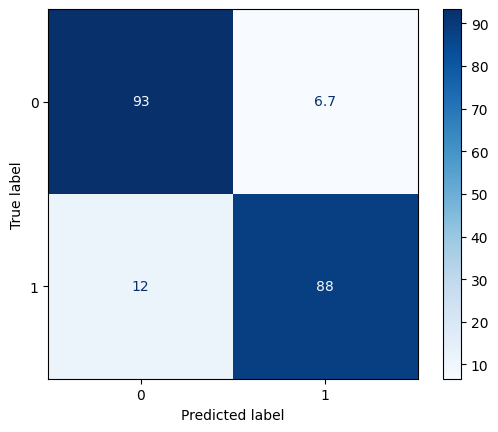

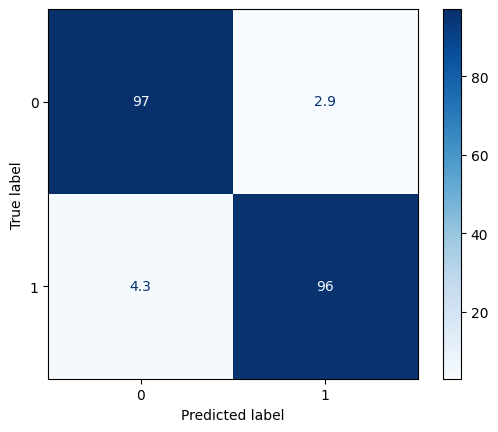

In [23]:
from sklearn.metrics import confusion_matrix

# CM full dataset
cm_FULL = confusion_matrix(y_test, y_predicted_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_FULL, display_labels=clf.classes_)
disp.plot()
plt.show()

# CM reduced dataset
cm_REDUCED = confusion_matrix(y_test, y_predicted_cv)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_REDUCED, display_labels=clf.classes_)
disp.plot()
plt.show()

# Normalize the confusion matrix to get percentages
cm_percentage_FULL = cm_FULL.astype('float') / cm_FULL.sum(axis=1)[:, np.newaxis] * 100  # Normalize and convert to percentage
cm_percentage_REDUCED = cm_REDUCED.astype('float') / cm_REDUCED.sum(axis=1)[:, np.newaxis] * 100  # Normalize and convert to percentage

# Display the confusion matrix with percentage values for full dataset
disp = ConfusionMatrixDisplay(confusion_matrix=cm_percentage_FULL, display_labels=clf.classes_)
disp.plot(cmap='Blues')  # Optional: Use color map for better visualization
plt.show()

# Display the confusion matrix with percentage values for reduced dataset
disp = ConfusionMatrixDisplay(confusion_matrix=cm_percentage_REDUCED, display_labels=clf.classes_)
disp.plot(cmap='Blues')  # Optional: Use color map for better visualization
plt.show()

